In [1]:
# library to convert .mat to np.array()
%pip install mat73

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
# Channel download
import mat73

data = mat73.loadmat('ChannelQriga_Freq_3kmh_Scena0_test_MIR_GIT_RAW_NR_3GPP_3D_UMa_NLOS_3p5GHz.mat')
# data

In [ ]:
import numpy as np

H_initial = data['Hfrq'][0]['Chan']
H_dl = H_initial.transpose(1, 0, 2, 3)[:12, :, 0:600:12, :15] / np.abs(H_initial.max())
H_dl.shape



(12, 4, 50, 15)

15

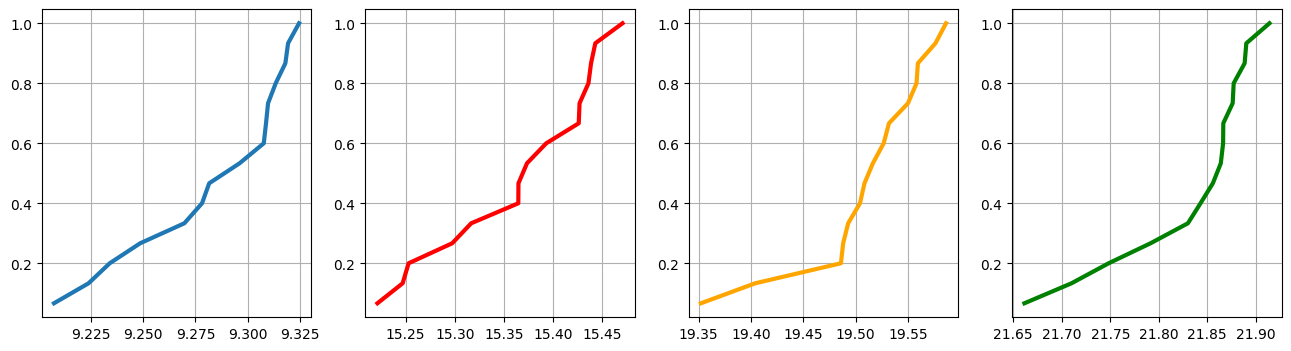

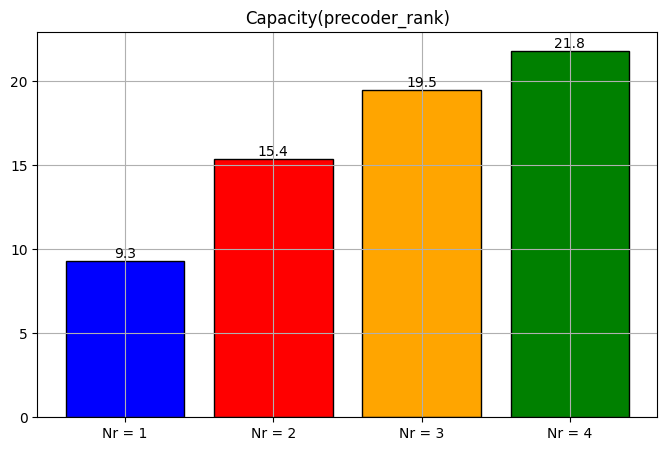

In [16]:
# Capacity of initial Channel
from extr_func import get_Capacity, cdf
import matplotlib.pyplot as plt


SNR = 30
channel_shape = list(H_dl.shape) + [1]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 строка, 4 столбца

Nr = 1  # precoder rank
Capacity1 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity1, Capacity_ideal_distr1 = cdf(Capacity1)
axs[0].plot(sort_capacity1, Capacity_ideal_distr1, lw=3)
axs[0].grid()

Nr = 2  # precoder rank
Capacity2 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity2, Capacity_ideal_distr2 = cdf(Capacity2)
axs[1].plot(sort_capacity2, Capacity_ideal_distr2, 'r', lw=3)
axs[1].grid()

Nr = 3  # precoder rank
Capacity3 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity3, Capacity_ideal_distr3 = cdf(Capacity3)
axs[2].plot(sort_capacity3, Capacity_ideal_distr3, 'orange', lw=3)
axs[2].grid()

Nr = 4  # precoder rank
Capacity4 = get_Capacity(H_dl, H_dl, Nr, SNR, channel_shape)
sort_capacity4, Capacity_ideal_distr4 = cdf(Capacity4)
axs[3].plot(sort_capacity4, Capacity_ideal_distr4, 'g', lw=3)
axs[3].grid()


Capacity1_mean = float(np.mean(Capacity1))
Capacity2_mean = float(np.mean(Capacity2))
Capacity3_mean = float(np.mean(Capacity3))
Capacity4_mean = float(np.mean(Capacity4))

categories = ['Nr = 1', 'Nr = 2', 'Nr = 3', 'Nr = 4']
values = [Capacity1_mean, Capacity2_mean, Capacity3_mean, Capacity4_mean]

plt.figure(figsize=(8, 5))
named_colors = ['b', 'r', 'orange', 'g']
bars = plt.bar(categories, values, color=named_colors, edgecolor='black')
plt.grid()

# Добавляем значения над столбцами
plt.title('Capacity(precoder_rank)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',  # Форматирование до 1 знака после запятой
             ha='center', va='bottom')
    
len(Capacity4)

In [17]:
# tensorly CPD_ALS
from tensorly.decomposition import parafac
from tensorly.cp_tensor import cp_to_tensor

RankCP = 8
weights, factors = parafac(H_dl, rank=RankCP, n_iter_max=100, tol=1e-6, verbose=True)

reconstruction error=0.7081164213062285
iteration 1, reconstruction error: 0.23413103481642658, decrease = 0.47398538648980193, unnormalized = 16.74019122364597
iteration 2, reconstruction error: 0.18708118384813638, decrease = 0.0470498509682902, unnormalized = 13.3761626023623
iteration 3, reconstruction error: 0.1720131401830131, decrease = 0.015068043665123265, unnormalized = 12.298808920830142
iteration 4, reconstruction error: 0.16428737803662374, decrease = 0.00772576214638937, unnormalized = 11.74642279320564
iteration 5, reconstruction error: 0.1602975805348745, decrease = 0.003989797501749243, unnormalized = 11.46115530111398
iteration 6, reconstruction error: 0.15808359532574087, decrease = 0.0022139852091336287, unnormalized = 11.302857039645652
iteration 7, reconstruction error: 0.1566646422179034, decrease = 0.0014189531078374618, unnormalized = 11.201402969785967
iteration 8, reconstruction error: 0.15566731700013872, decrease = 0.0009973252177646885, unnormalized = 11.1

Nr = 1:  0.34 %
Nr = 2:  0.8 %
Nr = 3:  0.97 %
Nr = 4:  1.51 %


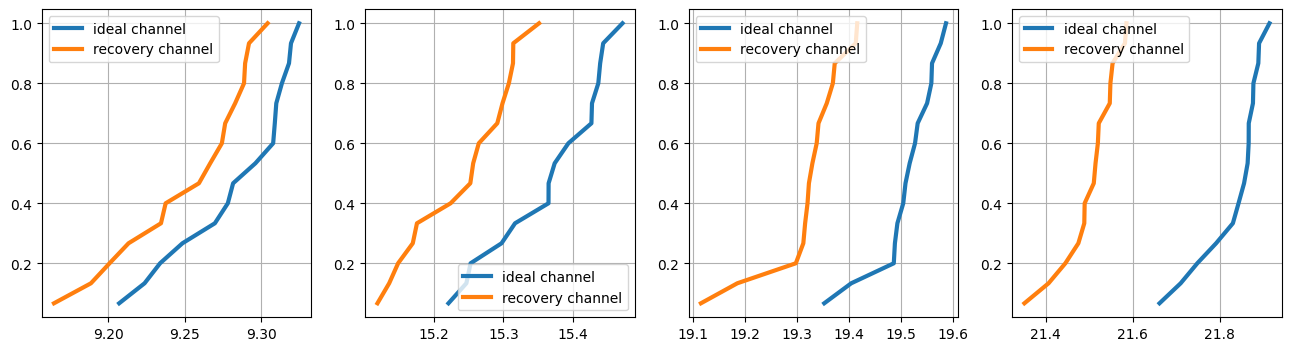

In [18]:

fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 строка, 4 столбца

H_dl_reconstr = cp_to_tensor((weights, factors))
ideal_capacity = [sort_capacity1, sort_capacity2, sort_capacity3, sort_capacity4]
ideal_cdf_capacity = [Capacity_ideal_distr1, Capacity_ideal_distr2, Capacity_ideal_distr3, Capacity_ideal_distr4]

errors = [0] * 4

for i in range(4):
    Nr = i + 1  # precoder rank
    Capacity_rec_1 = get_Capacity(H_dl, H_dl_reconstr, Nr, SNR, channel_shape)
    sort_capacity_rec, Capacity_rec_distr = cdf(Capacity_rec_1)
    axs[i].plot(ideal_capacity[i], ideal_cdf_capacity[i], lw=3)
    axs[i].plot(sort_capacity_rec, Capacity_rec_distr, lw=3)
    axs[i].grid()
    axs[i].legend(['ideal channel', 'recovery channel'])

    error = (np.mean(ideal_capacity[i]) - np.mean(sort_capacity_rec)) / np.mean(ideal_capacity[i]) * 100
    errors[i] = round(float(error), 2)
    # print(f'Error = {error} %')

for i in range(4):
    print(f'Nr = {i + 1}: ', errors[i], '%')


Iteration 0, relative error: 4.8376e-01
Iteration 1, relative error: 2.8630e-01
Iteration 2, relative error: 2.3618e-01
Iteration 3, relative error: 2.1667e-01
Iteration 4, relative error: 2.0821e-01
Iteration 5, relative error: 2.0318e-01
Iteration 6, relative error: 1.9900e-01
Iteration 7, relative error: 1.9519e-01
Iteration 8, relative error: 1.9176e-01
Iteration 9, relative error: 1.8868e-01
Iteration 10, relative error: 1.8590e-01
Iteration 11, relative error: 1.8341e-01
Iteration 12, relative error: 1.8120e-01
Iteration 13, relative error: 1.7926e-01
Iteration 14, relative error: 1.7756e-01
Iteration 15, relative error: 1.7610e-01
Iteration 16, relative error: 1.7483e-01
Iteration 17, relative error: 1.7375e-01
Iteration 18, relative error: 1.7280e-01
Iteration 19, relative error: 1.7198e-01
Iteration 20, relative error: 1.7126e-01
Iteration 21, relative error: 1.7061e-01
Iteration 22, relative error: 1.7002e-01
Iteration 23, relative error: 1.6947e-01
Iteration 24, relative err

{'lambdas': array([ 18.69298945,  20.76573311,  36.03079911,  53.08783242,
        100.78901725,  90.48128841,  56.04369105,  32.94652407]),
 'factors': [array([[ 0.18752216+1.70575869e-01j, -0.16247192-6.17784360e-03j,
           0.09395916-2.83952167e-01j, -0.25766593+1.28763174e-01j,
           0.02049376+2.29727521e-01j,  0.22101926+1.63780283e-02j,
           0.00289202+3.42852267e-02j, -0.19778833-2.16908005e-01j],
         [ 0.23213868+1.86419563e-01j,  0.21457492-9.69839273e-02j,
           0.28241571-1.60549187e-01j, -0.12116801-8.80462531e-02j,
          -0.18608724+1.96853552e-01j,  0.18005084+2.09197940e-01j,
           0.28607724+2.19429689e-01j,  0.04677432-3.32111013e-01j],
         [ 0.05561346+1.15367287e-01j,  0.17922844+2.69829985e-01j,
           0.29019968+5.71935263e-02j,  0.11343759-1.98103602e-01j,
          -0.22640333+9.99859319e-03j, -0.04501862+2.07786099e-01j,
           0.18804086+1.73196518e-02j,  0.24165267-1.64914091e-01j],
         [-0.03187417-2.44163

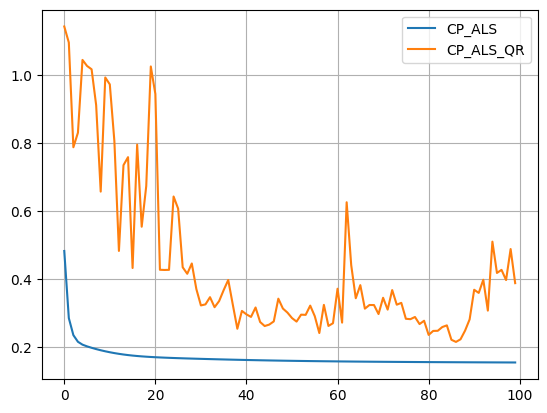

In [23]:
# my CPD_ALS and CPD_ALS_QR and CPD_Gradient compare (also test on images)
from CP_ALS import cp_als_complex, cp_als_qr_complex, reconstruct_tensor

data_cp_als = cp_als_complex(H_dl, RankCP, 100)
H_dl_reconstr = reconstruct_tensor(data_cp_als['lambdas'], data_cp_als['factors'])

data_cp_qr_als = cp_als_qr_complex(H_dl, RankCP, 100)
H_dl_qr_reconstr = reconstruct_tensor(data_cp_qr_als['lambdas'], data_cp_qr_als['factors'])

plt.plot(data_cp_als['errors'])
plt.plot(data_cp_qr_als['errors'])
plt.grid()
plt.legend(['CP_ALS', 'CP_ALS_QR'])

Nr = 1, CP_ALS Error:  0.61 %
Nr = 1, CP_ALS_QR Error:  1.56 %

Nr = 2, CP_ALS Error:  1.07 %
Nr = 2, CP_ALS_QR Error:  3.87 %

Nr = 3, CP_ALS Error:  1.16 %
Nr = 3, CP_ALS_QR Error:  6.93 %

Nr = 4, CP_ALS Error:  2.59 %
Nr = 4, CP_ALS_QR Error:  10.42 %



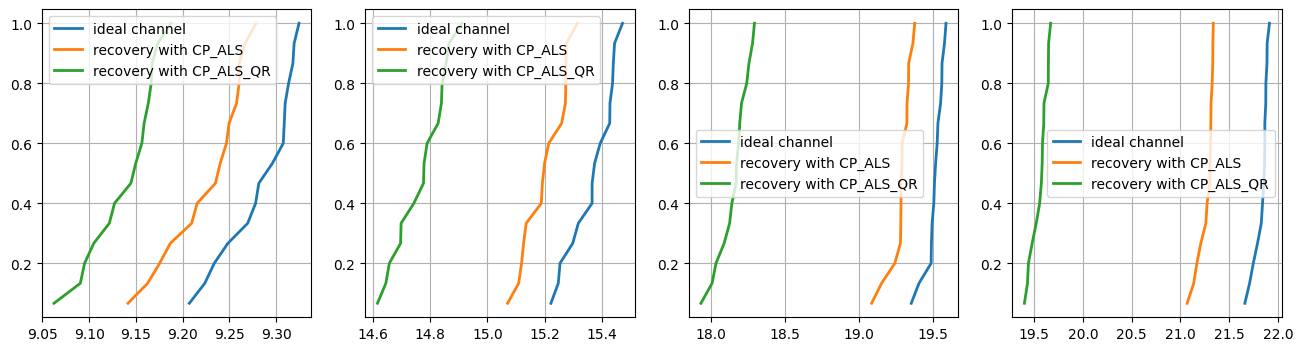

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 строка, 4 столбца

ideal_capacity = [sort_capacity1, sort_capacity2, sort_capacity3, sort_capacity4]
ideal_cdf_capacity = [Capacity_ideal_distr1, Capacity_ideal_distr2, Capacity_ideal_distr3, Capacity_ideal_distr4]

errors = [0] * 4

for i in range(4):
    Nr = i + 1  # precoder rank
    Capacity_rec_1 = get_Capacity(H_dl, H_dl_reconstr, Nr, SNR, channel_shape)
    sort_capacity_rec1, Capacity_rec_distr1 = cdf(Capacity_rec_1)

    Capacity_rec_2 = get_Capacity(H_dl, H_dl_qr_reconstr, Nr, SNR, channel_shape)
    sort_capacity_rec2, Capacity_rec_distr2 = cdf(Capacity_rec_2)

    axs[i].plot(ideal_capacity[i], ideal_cdf_capacity[i], lw=2)
    axs[i].plot(sort_capacity_rec1, Capacity_rec_distr1, lw=2)
    axs[i].plot(sort_capacity_rec2, Capacity_rec_distr2, lw=2)
    axs[i].grid()
    axs[i].legend(['ideal channel', 'recovery with CP_ALS', 'recovery with CP_ALS_QR'])

    error = (np.mean(ideal_capacity[i]) - np.mean(sort_capacity_rec1)) / np.mean(ideal_capacity[i]) * 100
    error_qr = (np.mean(ideal_capacity[i]) - np.mean(sort_capacity_rec2)) / np.mean(ideal_capacity[i]) * 100
    errors[i] = (round(float(error), 2), round(float(error_qr), 2))
    # print(f'Error = {error} %')

for i in range(4):
    print(f'Nr = {i + 1}, CP_ALS Error: ', errors[i][0], '%')
    print(f'Nr = {i + 1}, CP_ALS_QR Error: ', errors[i][1], '%')
    print()

In [33]:
print('Initial shape: ', H_dl.shape)
print()
print('Shape after compression: ')
print(data_cp_als['factors'][0].shape)
print(data_cp_als['factors'][1].shape)
print(data_cp_als['factors'][2].shape)
print(data_cp_als['factors'][3].shape)

Initial shape:  (12, 4, 50, 15)

Shape after compression: 
(12, 8)
(4, 8)
(50, 8)
(15, 8)


In [36]:
V1 = 12 * 4 * 50 * 15
V2 = (12 + 4 + 50 + 15) * RankCP

print(V1, V2)
print('Сжатие в ', round(V1 / V2, 2), 'раз')

36000 648
Сжатие в  55.56 раз


In [ ]:
# My method compression: Tensorization + CPD_ALS on MIMO channel


In [ ]:
#AutoRank